# **Run it all**

In [ ]:
# Install snscrape library for webscraping
!pip3 install snscrape;
# Install transformers library
!pip install transformers;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 3.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 16.4 MB/s eta 0:00:00


In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from transformers import pipeline
from textblob import TextBlob
from tqdm import tqdm
from collections import Counter

# Import finbert model
classifier = pipeline('sentiment-analysis', model="ProsusAI/finbert")

FinBERT is a pre-trained NLP model to analyze sentiment of financial text. It is built by further training the BERT language model in the finance domain, using a large financial corpus and thereby fine-tuning it for financial sentiment classification.

# **Obtaining the Tweets**

In [ ]:
# Define the keyword and the number of tweets to scrape
QUERY = 'nifty50'
N_TWEETS = 500

# Create an empty list to store the attributes of the tweets
attributes_container = []

# Scrape the tweets and extract the specified attributes
for i, tweet in tqdm(
    enumerate(sntwitter.TwitterSearchScraper(QUERY).get_items()), total=N_TWEETS
):
    if i > N_TWEETS:
        break
    # Store necessory data for sentiment analysis
    attributes_container.append(
        [   tweet.date,
            tweet.likeCount,
            tweet.content,
            tweet.hashtags,
        ]
    )

# Create a dataframe from the attributes list
tweets_df = pd.DataFrame(
    attributes_container,
    columns=[
        "Date_Created",
        "Like_Count",
        "tweet_Content",
        "Hashtags",
    ],
)

  0%|          | 0/500 [00:00<?, ?it/s]ERROR:snscrape.base:Error retrieving https://api.twitter.com/2/search/adaptive.json?include_profile_interstitial_type=1&include_blocking=1&include_blocked_by=1&include_followed_by=1&include_want_retweets=1&include_mute_edge=1&include_can_dm=1&include_can_media_tag=1&include_ext_has_nft_avatar=1&include_ext_is_blue_verified=1&include_ext_verified_type=1&skip_status=1&cards_platform=Web-12&include_cards=1&include_ext_alt_text=true&include_ext_limited_action_results=false&include_quote_count=true&include_reply_count=1&tweet_mode=extended&include_ext_collab_control=true&include_ext_views=true&include_entities=true&include_user_entities=true&include_ext_media_color=true&include_ext_media_availability=true&include_ext_sensitive_media_warning=true&include_ext_trusted_friends_metadata=true&send_error_codes=true&simple_quoted_tweet=true&q=nifty50&tweet_search_mode=live&count=20&query_source=spelling_expansion_revert_click&pc=1&spelling_corrections=1&includ

ScraperException: ignored

# **Sentiment Analysis Using TextBlob**

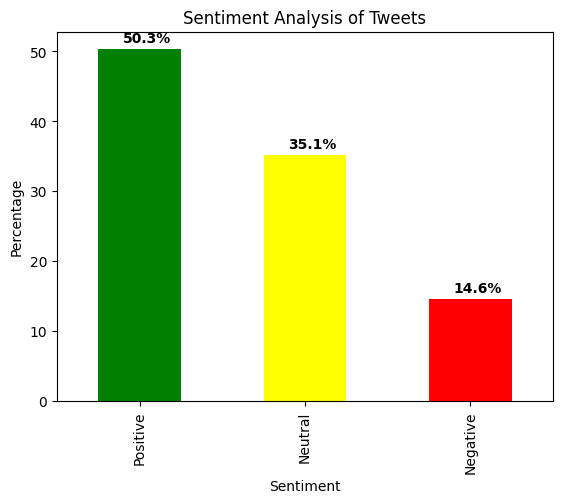

In [ ]:
# Add a new column to the dataframe to store the sentiment
tweets_df['Sentiment'] = tweets_df['tweet_Content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Create a new column to categorize the sentiment as positive, neutral or negative
tweets_df['Sentiment_Category'] = tweets_df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Neutral' if x == 0 else 'Negative')

# Calculate the percentage of each sentiment category
sentiment_counts = tweets_df['Sentiment_Category'].value_counts(normalize=True) * 100

# Create a bar plot of the sentiment category with percentage values on top of bars
ax = sentiment_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.set_title('Sentiment Analysis of Tweets')

# Add percentage values on top of bars
for i, v in enumerate(sentiment_counts):
    ax.text(i - 0.1, v + 1, f'{v:.1f}%', color='black', fontweight='bold')

plt.show()

In [ ]:
tweets_df['Sentiment_Category'].value_counts()*100/len(tweets_df)

Positive    50.299401
Neutral     35.129741
Negative    14.570858
Name: Sentiment_Category, dtype: float64

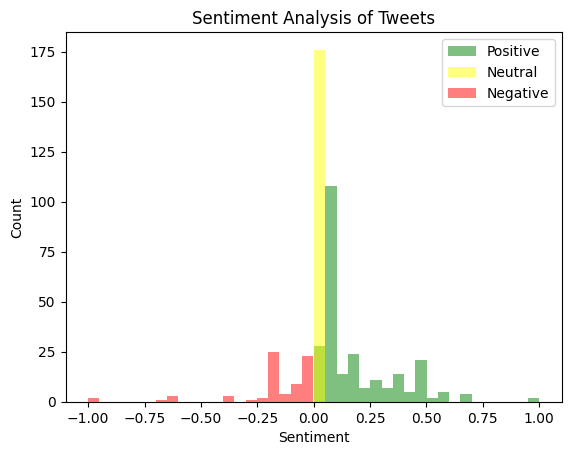

In [ ]:
# Create a histogram of the sentiment
plt.hist(tweets_df[tweets_df['Sentiment'] > 0]['Sentiment'], bins=20, color='green', alpha=0.5, label='Positive')
plt.hist(tweets_df[tweets_df['Sentiment'] == 0]['Sentiment'], bins=20, color='yellow', alpha=0.5, label='Neutral')
plt.hist(tweets_df[tweets_df['Sentiment'] < 0]['Sentiment'], bins=20, color='red', alpha=0.5, label='Negative')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend()
plt.title('Sentiment Analysis of Tweets')
plt.show()
     

# **Sentiment Analysis Using FinBERT**

100%|██████████| 501/501 [03:03<00:00,  2.73it/s]


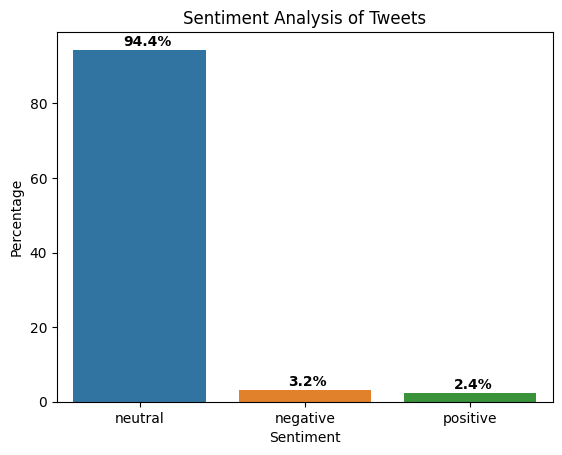

In [ ]:
# Add a new column to the dataframe to store the sentiment
tweets_df['Sentiment'] = [classifier(x)[0]['label'] for x in tqdm(tweets_df['tweet_Content'])]

# Count the number of tweets for each sentiment
counts = tweets_df['Sentiment'].value_counts()

# Calculate the percentage of each sentiment category
sentiment_counts = counts / len(tweets_df) * 100

# Plot the sentiment counts using a bar plot with percentage values on top of bars
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Percentage')
ax.set_title('Sentiment Analysis of Tweets')

# Add percentage values on top of bars
for i, v in enumerate(sentiment_counts):
    ax.text(i - 0.1, v + 1, f'{v:.1f}%', color='black', fontweight='bold')

# Show the plot
plt.show()

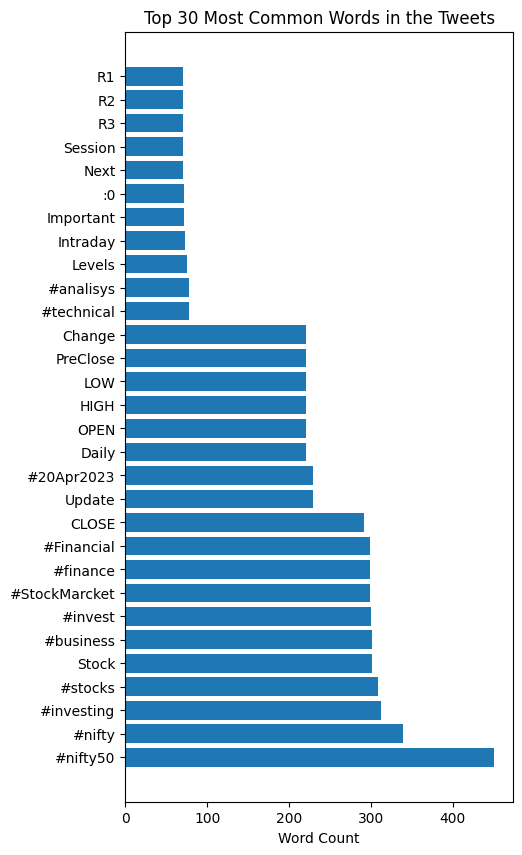

In [ ]:
# Create a list of all the words in the tweets
words_list = ' '.join(tweets_df['tweet_Content']).split()
unwanted_words = ['the', 'and', 'is', 'in', 'to', 'of', 'it', 'with', 'for', 'on',':','30',"RT","https","co","nifty50","min","RSI","nifty","stockmarket","t","finicial","Analysis","business",]

# Use a list comprehension to remove the unwanted words from the original list
filtered_words = [word for word in words_list if word.lower() not in unwanted_words]
# Count the frequency of each word
word_counts = Counter(filtered_words)

# Get the top 10 most common words
top_words = word_counts.most_common(30)
plt.figure(figsize=(5,10))
# Create a horizontal bar plot of the word counts
plt.barh(range(len(top_words)), [count for _,count in top_words], align='center')
plt.yticks(range(len(top_words)), [word for word, _ in top_words])
plt.xlabel('Word Count')
plt.title('Top 30 Most Common Words in the Tweets')
plt.show()
     

In [ ]:
from joblib import dump

In [ ]:
dump(classifier, r"C:\Users\aiden\OneDrive\Desktop\djangoBaby\sentiAnalysis\savedModels")

['C:\\Users\\aiden\\OneDrive\\Desktop\\djangoBaby\\sentiAnalysis\\savedModels']